In [1]:
sc

In [22]:
# from pyspark import SparkConf, SparkContext

# # In Jupyter you have to stop the current context first
# sc.stop()

# # Create new config
# conf = (SparkConf()
#     .set("spark.driver.maxResultSize", "10g"))

# # Create new context
# sc = SparkContext(conf=conf)

In [2]:
import numpy as np
import optimize_camera as optimize
import project_lidar as project
import matplotlib.pyplot as pl
%matplotlib inline

In [3]:
def colin(params, xyz_a):

	# Unwrap params
	kappa, phi, omega, xs, ys, zs, f = params

	omega = float(omega)
	phi = float(phi) + 0.5*np.pi
	kappa = float(kappa)
	xs = float(xs)
	ys = float(ys)
	zs = float(zs)
	f = float(f)

	# -- utils
	co = np.cos(omega)
	so = np.sin(omega)
	cp = np.cos(phi)
	sp = np.sin(phi)
	ck = np.cos(kappa)
	sk = np.sin(kappa)

	a1 =  cp*ck+sp*so*sk
	b1 =  cp*sk+sp*so*ck
	c1 =  sp*co
	a2 = -co*sk
	b2 =  co*ck
	c2 =  so
	a3 =  sp*ck+cp*so*sk
	b3 =  sp*sk-cp*so*ck
	c3 =  cp*co

	ynum  = a1*(xyz_a[:,0]-xs)+b1*(xyz_a[:,1]-ys)+c1*(xyz_a[:,2]-zs)
	xnum  = a2*(xyz_a[:,0]-xs)+b2*(xyz_a[:,1]-ys)+c2*(xyz_a[:,2]-zs)
	denom = a3*(xyz_a[:,0]-xs)+b3*(xyz_a[:,1]-ys)+c3*(xyz_a[:,2]-zs)

	xx = -f*xnum/denom
	yy = f*ynum/denom

	return np.vstack([xx,yy]).T

In [4]:
def project(content):
    import numpy as np
    import colin
    from project_lidar import in_picture
    from project_lidar import distance

    # Finds the desired projection
    
#     if globparams == None:
#         params = return_params(globname)
#     else:
#         params = globparams

    params = [4.48603184e+00, -6.39366995e-02, 1.01077828e-35, 9.88508193e+05,
          2.14483372e+05, 7.97190735e+02, 2.85647278e+03]

    omega, phi, kappa, xs, ys, zs, f = params
    image_dims = [1918, 2560]
    image_dims_reversed = np.array([image_dims[1], \
        image_dims[0]])

    # Rearrange
#     print "working on: ", filename
#     dat = np.load(filename).copy()
    dat = np.frombuffer(bytes(content))
    dat = dat[10:].reshape(-1, 3)
    

    # Multiply by -1 because it apears as inverse; use orient?
    pixel_xy = 1.0*colin.colin(params, dat) 

    # un-center pixel (x,y)
    x = image_dims[0]/2 - pixel_xy[:,0].astype(int)
    y = image_dims[1]/2 + pixel_xy[:,1].astype(int)

    is_in_picture = in_picture(x,y,image_dims)

    index = np.arange(is_in_picture.size)[is_in_picture>0]

    print "npix = ", index.size

    distgrid = np.ones(image_dims_reversed)*(100000.0)
    xgrid =  -1.*np.ones(image_dims_reversed)
    ygrid = -1.*np.ones(image_dims_reversed)

    if index.size==0:
        #print "no points, returning..."
        return [distgrid, xgrid, ygrid]
        #yield [distgrid, xgrid, ygrid]

    n   = distance(xs,ys,zs, dat[index,0],dat[index,1],dat[index,2]) 
    x   = x[index]
    y   = y[index]
    dat = dat[index]

    # Add each point to the arrays, given it is visibile (vis[i] == 1)
    # And it is closer to the camera than the current value stored in 
    # the corresponding pixel of the distance array

    nx = distgrid.shape[1]-1
    ny = distgrid.shape[0]-1

    for ii in range(index.size):
        if n[ii]<distgrid[ny-y[ii],nx-x[ii]] and n[ii]>500:
            distgrid[ny-y[ii],nx-x[ii]] = n[ii]
            xgrid[ny-y[ii],nx-x[ii]] = dat[ii,0]
            ygrid[ny-y[ii],nx-x[ii]] = dat[ii,1]

    #print "Done with: ",filename
    return [distgrid, xgrid, ygrid]
    print xgrid[0,0]
    #yield [distgrid, xgrid, ygrid]


In [6]:
def merge(final, new):
    
    out = [0, 0, 0]
    replace = np.greater(final[0], new[0])
    out[0] = final[0]*np.logical_not(replace) + new[0]*replace
    out[1] = final[1]*np.logical_not(replace) + new[1]*replace
    out[2] = final[2]*np.logical_not(replace) + new[2]*replace
    
    return out

In [14]:
def proj_npy(tile):
    import colin
    from project_lidar import in_picture
    from project_lidar import distance
    
    array=np.frombuffer(bytes(tile[1]))
    dat = array[10:].reshape(-1, 3)
    
    params = [1.345794960057916, 0.056072502823257861, -0.012072660480989369, 988504.86108153069,
              214494.40203705645, 799.41113612974959, 2831.8189679364423]

    omega, phi, kappa, xs, ys, zs, f = params
    image_dims = [1918, 2560]
    image_dims_reversed = np.array([image_dims[1], \
        image_dims[0]])
    
    # Multiply by -1 because it apears as inverse; use orient?
    pixel_xy = 1.0*colin.colin(params, dat)
    
    # un-center pixel (x,y)
    x = image_dims[0]/2 + pixel_xy[:,0].astype(int)
    y = image_dims[1]/2 + pixel_xy[:,1].astype(int)
    
    is_in_picture = in_picture(x,y,image_dims)
    
    index = np.arange(is_in_picture.size)[is_in_picture>0]
    
    distgrid = np.ones(image_dims_reversed)*(100000.0)
    xgrid =  -1.*np.ones(image_dims_reversed)
    ygrid = -1.*np.ones(image_dims_reversed)
    
    if index.size==0:
        return [distgrid, xgrid, ygrid]

    n   = distance(xs,ys,zs, dat[index,0],dat[index,1],dat[index,2]) 
    x   = x[index]
    y   = y[index]
    dat = dat[index]

    # Add each point to the arrays, given it is visibile (vis[i] == 1)
    # And it is closer to the camera than the current value stored in 
    # the corresponding pixel of the distance array

#     nx = distgrid.shape[1]-1
#     ny = distgrid.shape[0]-1

    for ii in range(index.size):
        if n[ii]<distgrid[y[ii], x[ii]] and n[ii]>100:
            distgrid[y[ii],x[ii]] = n[ii]
            xgrid[y[ii],x[ii]] = dat[ii,0]
            ygrid[y[ii],x[ii]] = dat[ii,1]

    
    return [distgrid, xgrid, ygrid]

In [54]:
rdd = sc.binaryFiles('data_npy_test/*')
# a = rdd.map(proj_npy).reduce(merge)
a = rdd.map(proj_npy)

In [56]:
b = a.collect()

In [58]:
b[0]

[array([[ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        ..., 
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.],
        [ 100000.,  100000.,  100000., ...,  100000.,  100000.,  100000.]]),
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ..., 
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]),
 array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ..., 
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [

In [ ]:
data_npy_test/

## Debugging Save to npy

In [47]:
type(a[0])

numpy.ndarray

In [49]:
np.save('test.npy', a[0])

In [50]:
b = np.load('test.npy')

In [51]:
b.shape

(2560L, 1918L)

In [22]:
from PIL import Image

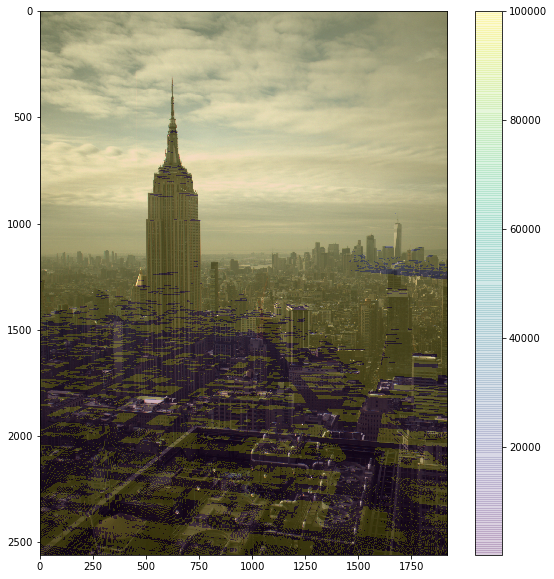

In [24]:
pl.figure(figsize=(10,10))

im = Image.open('./bof_left.png')
imarray = np.array(im)
# pl.imshow(imarray[900:1300, 1550:1850])
# pl.imshow(a[0][900:1300, 1550:1850], alpha=0.5)
pl.imshow(imarray)
pl.imshow(a[0], alpha=0.2)
pl.colorbar()




In [28]:
final_grids = a

# Cascade to fill holes by covering a given point if there is 
# a closer point above it
print "Smoothing vertically..."
for i in range(0, len(final_grids[0])-1):
    for j in range(0, len(final_grids[0][0])):
        if final_grids[0][i][j] < final_grids[0][i + 1][j]:
            final_grids[0][i+1][j] = final_grids[0][i][j]
            final_grids[1][i+1][j] = final_grids[1][i][j]
            final_grids[2][i+1][j] = final_grids[2][i][j]

# Smooth pixels to get rid of vertical bars
print "Smoothing horizontally..."
for i in range(0, len(final_grids[0])-1):
    for j in range(1, len(final_grids[0][0])-2):
        if final_grids[0][i][j] != final_grids[0][i][j-1] and \
            final_grids[0][i][j+1] == final_grids[0][i][j+1]:
            final_grids[0][i][j] = final_grids[0][i][j+1]
            final_grids[1][i][j] = final_grids[1][i][j+1]
            final_grids[2][i][j] = final_grids[2][i][j+1]
# Smooth pixels two wide
print "Smoothing horizontally [2 pixels]..."
for i in range(0, len(final_grids[0])-1):
    for j in range(1, len(final_grids[0][0])-4):
        if final_grids[0][i][j] != final_grids[0][i][j-1] and \
            final_grids[0][i][j] == final_grids[0][i][j+1] and \
            final_grids[0][i][j-1] == final_grids[0][i][j+2]:
            final_grids[0][i][j] = final_grids[0][i][j+2]
            final_grids[1][i][j] = final_grids[1][i][j+2]
            final_grids[2][i][j] = final_grids[2][i][j+2]
            final_grids[0][i][j+1] = final_grids[0][i][j+2]
            final_grids[1][i][j+1] = final_grids[1][i][j+2]
            final_grids[2][i][j+1] = final_grids[2][i][j+2]


Smoothing vertically...
Smoothing horizontally...
Smoothing horizontally [2 pixels]...


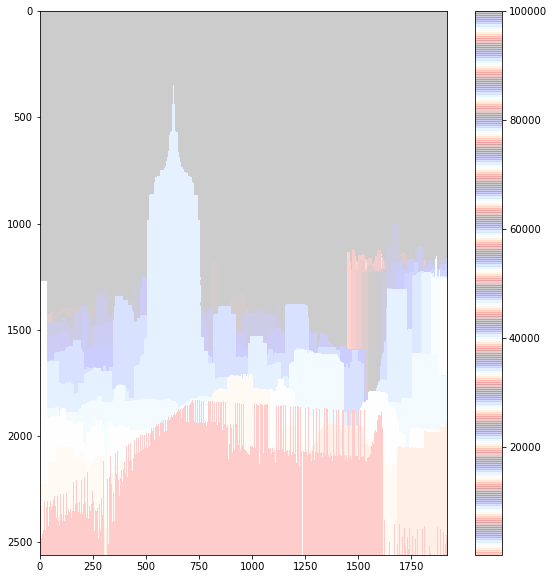

In [43]:
pl.figure(figsize=(10,10))

im = Image.open('./bof_left.png')
imarray = np.array(im)
# pl.imshow(imarray[900:1300, 1550:1850])
# pl.imshow(a[0][900:1300, 1550:1850], alpha=0.5)
#pl.imshow(imarray)
pl.imshow(a[0], alpha=0.2, cmap = 'flag')
pl.colorbar()




In [ ]:
distgri